# Рекомендация тарифов

Имеются данные о поведении клиентов, которые уже перешли на один из двух тарифов. Нужно построить модель для задачи классификации, которая выберет подходящий тариф пользователю.
Чтобы сдать проект успешно, нужно довести значение *accuracy* на тестовой выборке до 0,75 и более. 

## Изучение данных

### Общая информация

***Импортируем необходимые библиотеки и загрузим файл.***

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
import numpy as np

df = pd.read_csv('/datasets/users_behavior.csv')

***Рассмотрим датафрейм подробнее***

In [2]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**3214 пользователя. Признаки, на основе которых будут строиться модели - количество звонков, их длительность, количество отправленных сообщений и объем использованного трафика.**

***Найдем долю пользователей тарифа "Ультра", чтобы убедиться в репрезентативности выборки***

In [4]:
df['is_ultra'].mean()

0.30647168637212197

**Соотношение удовлетворительное**

### Мультиколлинеарность факторов

**Проверим датафрейм на наличие мультиколлинеарных признаков. Для этого построим матрицу рассеяния.**

array([[<AxesSubplot:xlabel='calls', ylabel='calls'>,
        <AxesSubplot:xlabel='minutes', ylabel='calls'>,
        <AxesSubplot:xlabel='messages', ylabel='calls'>,
        <AxesSubplot:xlabel='mb_used', ylabel='calls'>,
        <AxesSubplot:xlabel='is_ultra', ylabel='calls'>],
       [<AxesSubplot:xlabel='calls', ylabel='minutes'>,
        <AxesSubplot:xlabel='minutes', ylabel='minutes'>,
        <AxesSubplot:xlabel='messages', ylabel='minutes'>,
        <AxesSubplot:xlabel='mb_used', ylabel='minutes'>,
        <AxesSubplot:xlabel='is_ultra', ylabel='minutes'>],
       [<AxesSubplot:xlabel='calls', ylabel='messages'>,
        <AxesSubplot:xlabel='minutes', ylabel='messages'>,
        <AxesSubplot:xlabel='messages', ylabel='messages'>,
        <AxesSubplot:xlabel='mb_used', ylabel='messages'>,
        <AxesSubplot:xlabel='is_ultra', ylabel='messages'>],
       [<AxesSubplot:xlabel='calls', ylabel='mb_used'>,
        <AxesSubplot:xlabel='minutes', ylabel='mb_used'>,
        <AxesSubpl

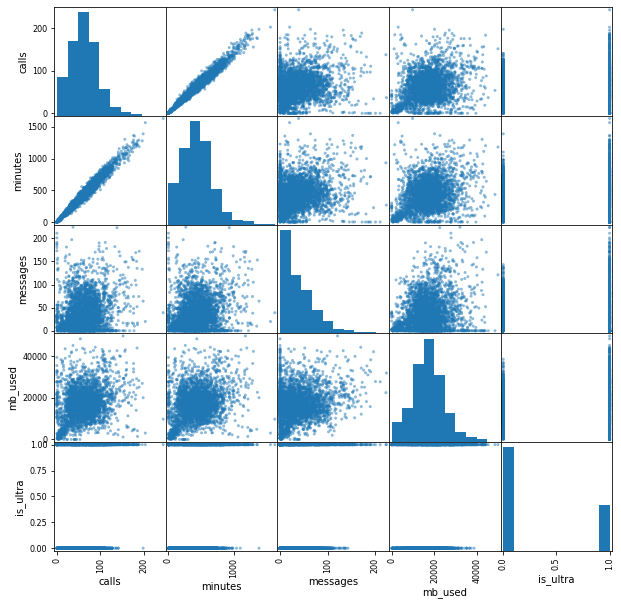

In [5]:
pd.plotting.scatter_matrix(df, figsize=(10, 10))

**Видим четкую линейную зависимость признаков minutes (количество использованных минут) и calls (количество совершенных звонков). Найдем коэффициент корреляции между ними.**

In [6]:
df['calls'].corr(df['minutes'])

0.9820832355742293

**Коэффициент корреляции почти равен единице. Для снижения нагрузки на нашу модель исключим столбец с количеством звонков из дальнейшего анализа. Как мы знаем, в тарифный пакет входит именно количество минут, а не количество звонков.**

In [7]:
df = df.drop('calls', axis=1)

## Разбиение данных на выборки

***Разобьем данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Для этого дважды используем train_test_split.***

***Сперва выделим признаки для обучения. Целевой категориальный признак - это столбец 'is_ultra'.***

In [8]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

***Выделим обучающую выборку. Валидационную и тестовую выборки пока выделим в переменные '_temp'***

In [9]:
features_train, features_temp, target_train, target_temp = train_test_split(features, target, train_size=.6, random_state=12345)

***Оставшиеся данные поделим пополам - по 1/5 от исходного датасета для валидационной и тестовой выборок***

In [10]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, train_size=.5, random_state=12345)

***Проверим результат разбивки***

In [11]:
print('Соотношение обучающей, валидационной и тестовой выборок: {:.0f} : {:.0f} : 1'.format(
    len(features_train)/len(features_test), len(features_valid)/len(features_test)))

Соотношение обучающей, валидационной и тестовой выборок: 3 : 1 : 1


In [12]:
print('Размер обучающей, валидационной и тестовой выборок: {}, {}, {}'.format(
    features_train.shape, features_valid.shape, features_test.shape))

Размер обучающей, валидационной и тестовой выборок: (1928, 3), (643, 3), (643, 3)


**Разбивка выполнена успешно, перейдем к выбору модели**

## Исследование моделей

***Проанализируем работу трех видов моделей (решающее дерево, случайный лес и логистическую регрессию), чтобы выбрать лучшую модель для проверки на тестовой выборке.***

### Решающее дерево

***Переберем максимальную глубину дерева от 1 до 10 для выявления самой точной модели***

In [13]:
best_model_tree = None
best_accuracy_tree = 0
best_depth_tree = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predict_valid)
    if accuracy > best_accuracy_tree:
        best_accuracy_tree = accuracy
        best_model_tree = model
        best_depth_tree = depth
print('Наибольшая полученная точность модели составляет {:.2f} при глубине дерева: {}'.format(best_accuracy_tree, best_depth_tree))

Наибольшая полученная точность модели составляет 0.79 при глубине дерева: 4


**Точность модели невысокая, ошибки составляют больше 20%. Проверим модель случайного леса.**

### Случайный лес

***Переберем модели с количеством деревьев от 10 до 50 (шаг 10) и с глубиной от 1 до 10 для выявления самой точной модели***

In [14]:
best_model_forest = None
best_accuracy_forest = 0
best_est = 0
best_depth_forest = 0
for est in range(10, 51, 10):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth)
        model.fit(features_train, target_train)
        accuracy = model.score(features_valid, target_valid)
        if accuracy > best_accuracy_forest:
            best_model_forest = model
            best_accuracy_forest = accuracy
            best_est = est
            best_depth_forest = depth
print('Наибольшая полученная точность модели составляет {:.2f} при количестве деревьев {} и глубине дерева {}'.format(
    best_accuracy_forest, best_est, best_depth_forest))

Наибольшая полученная точность модели составляет 0.80 при количестве деревьев 20 и глубине дерева 8


**Полученная точность выше модели с предыдущей, но работа модели с 20 деревьями глубиной 8 требует много ресурсов. Рассмотрим модель логистической регрессии.**

### Логистическая регрессия

***Посчитаем точность модели логистической регрессии***

In [15]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
accuracy = model.score(features_valid, target_valid)
print('Точность модели составляет {:.2f}'.format(accuracy))

Точность модели составляет 0.71


**Точность модели получилась наименьшая, но стоит отметить высокую скорость работы модели.**

## Проверка модели на тестовой выборке

***Наибольшая точность получена у модели случайного леса. Проверим ее на тестовой выборке.***

In [16]:
accuracy_test = best_model_forest.score(features_test, target_test)
print('Точность лучшей модели на тестовой выборке составляет {:.2f}'.format(accuracy_test))

Точность лучшей модели на тестовой выборке составляет 0.80


**Проверка модели на тестовой выборке пройдена - точность составила 80%.**

**Для увеличения точности модели обучим ее на обучающей + валидационной выборках, после чего применим модель к тестовой выборке. Оптимальные гиперпараметры были определены ранее.**

**Объединим датафреймы с обучающей и валидационной выборками**

In [17]:
features_final = features_train.append(features_valid, ignore_index=True) 
target_final = target_train.append(target_valid, ignore_index=True)

**Обучим модель на объединенных выборках и проверим ее на тестовой выборке.**

In [18]:
model_final = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth_forest)
model_final.fit(features_final, target_final)
model_final_pred = model_final.predict(features_test)
accuracy_test_final = model_final.score(features_test, target_test)
print('Точность модели на тестовой выборке составляет {:.2f}'.format(accuracy_test_final))

Точность модели на тестовой выборке составляет 0.81


**Точность модели, обученной на более широкой выборке, оказалась выше.**

## Проверка модели на адекватность

### Случайное число

***Сравним точность нашей модели на тестовой выборке с моделью, которая выдает случайное число***

***Создадим Series с набором случайных значений 0 или 1 размером с тестовую выборку***

In [19]:
random_result = pd.Series(np.random.binomial(1, 0.5, size=len(target_test))) 

***Проверим точность этой модели на тестовой выборке***

In [20]:
random_result_accuracy = accuracy_score(target_test, random_result)
print('Точность модели со случайными данными составляет {:.2f}'.format(random_result_accuracy))

Точность модели со случайными данными составляет 0.50


**Точность такого метода существенно ниже полученной, что указывает на вменяемость нашей модели.**

### DummyClassifier

**Проверим модель на вменяемость с помощью инструментов библиотеки DummyClassifier.**

In [21]:
model_dummy = DummyClassifier(strategy='most_frequent')
model_dummy.fit(features_final, target_final)
model_dummy_pred = model_dummy.predict(features_test)
print('Точность модели DummyClassifier со стратегией "most_frequent" составляет {:.2f}'.format(
    model_dummy.score(features_test, target_test)))

Точность модели DummyClassifier со стратегией "most_frequent" составляет 0.68


**Полученная точность выше 50%, но существенно ниже полученной на нашей модели.**

**Рассмотрим результаты рабочей модели и модели DummyClassifier на confusion_matrix**

In [22]:
print('confusion_matrix для рабочей модели:')
confusion_matrix(target_test, model_final_pred)

confusion_matrix для рабочей модели:


array([[412,  28],
       [ 95, 108]])

In [23]:
print('confusion_matrix для модели "most_frequent":')
confusion_matrix(target_test, model_dummy_pred)

confusion_matrix для модели "most_frequent":


array([[440,   0],
       [203,   0]])

**В связи с тем, что в исходной выборке доля пользователей тарифа "Смарт" выше, модель 'most_frequent' угадала большее количество пользователей этого тарифа (а точнее, всех) по сравнению с рабочей моделью (440 против 412 пользователей). По остальным параметрам работа нашей финальной модели существенно лучше.**

## Вывод

**Были рассмотрены 3 вида модели - решающее дерево, случайный лес и логистическая регрессия. Наибольшую точность показала модель случайного леса (0,80), наименьшую - модель логистической регрессии (0,71). Стоит отметить, что модель случайного леса требует наибольшее количество ресурсов, модель логистической регрессии - наименьшее. Модель решающего дерева показала средний результат (79%), затраты вычислительной мощности на нее также средние. Путем перебора найдены оптимальные гиперпараметры для нашей модели: количество деревьев 20, глубина дерева 8.**

**Результат проверки на тестовой выборке удовлеворительный, точность составила 0,80. После обучения модели с выявленными оптимальными гиперпараметрами на выборке общучающая + валидационная точность модели выросла до 0.81.**

**Проверка модели на вменяемость прошла успешно.**